In [25]:
import itertools
import pandas as pd
from collections import Counter
import numpy as np

table = pd.read_csv('finalTrain.csv')


accents = list(set(table.accent))
genders = list(set(table.gender))
classes = sorted([e for e in itertools.product(accents, genders)])
print (len(classes))
print (classes)


12
[('australia', 'female'), ('australia', 'male'), ('canada', 'female'), ('canada', 'male'), ('england', 'female'), ('england', 'male'), ('indian', 'female'), ('indian', 'male'), ('scotland', 'female'), ('scotland', 'male'), ('us', 'female'), ('us', 'male')]


In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from tqdm.auto import tqdm

from os import path, listdir
from collections import Counter
import ftfy
import string

allowed = string.ascii_lowercase + string.digits + " $&%+/-'"
allowed_set = set(allowed)

def clean(s):
  s = ftfy.fix_text(s, normalization='NFKD').lower()
  s = s.encode('ascii','ignore').decode('ascii')
  return ''.join(c for c in s if c in allowed_set)


char2index = { c: i for i, c in enumerate('<>' + allowed ) }

class CommonVoiceDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, root_dir):
    self.csv_file = csv_file
    self.table = pd.read_csv(csv_file)
    self.root_dir = root_dir
    file_names = []
    mfccs = []
    for f in tqdm(sorted(listdir(root_dir))):
        mfcc = torch.Tensor(np.load(path.join(self.root_dir, f)))
        if len(mfcc) > 300:
            continue
        mfccs.append(mfcc)
        file_names.append(f)
        
    self.mfccs = mfccs
    self.file_names = file_names
    
  def __getitem__(self, i):
    mfcc = self.mfccs[i] # torch.Tensor(np.load(path.join(self.root_dir, self.file_names[i])))
    
    row = self.table[self.table.path == self.file_names[i].replace('.npy', '')]
    [sentence], [age], [accent], [gender] = row.sentence, row.age, row.accent, row.gender
    
    t = classes.index((accent, gender))
    target = F.one_hot(torch.tensor([t] * len(mfcc)), num_classes=len(classes)).float() 
    feature = torch.cat([mfcc, target], 1)
    
    sentence = '<' + clean(sentence) + '>'
    sentence = torch.Tensor([char2index[c] for c in sentence])
    return feature, torch.tensor([len(feature)]), sentence, torch.tensor([len(sentence)])

  def __len__(self):
    return len(self.file_names)

def collate(batch):
  inp, inp_len, op, op_len = zip(*batch)
  inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=len(char2index))
  inp_len = torch.stack(inp_len)
  op = torch.cat(op) 
  op_len = torch.stack(op_len)
  return inp, inp_len, op, op_len 


import torch.nn.init as init

def weight_init(m):
  if isinstance(m, nn.Linear):
    init.xavier_normal_(m.weight.data)
    init.normal_(m.bias.data)
  elif isinstance(m, nn.LSTM):
    for param in m.parameters():
      if len(param.shape) >= 2:
        init.orthogonal_(param.data)
      else:
        init.normal_(param.data)

valid_data = CommonVoiceDataset('finalVal.csv', 'validation')
train_data = CommonVoiceDataset('finalTrain.csv', 'train')

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f6fecbb7320>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [27]:
char2index

{'<': 0,
 '>': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '0': 28,
 '1': 29,
 '2': 30,
 '3': 31,
 '4': 32,
 '5': 33,
 '6': 34,
 '7': 35,
 '8': 36,
 '9': 37,
 ' ': 38,
 '$': 39,
 '&': 40,
 '%': 41,
 '+': 42,
 '/': 43,
 '-': 44,
 "'": 45}

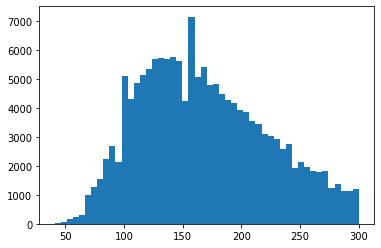

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([len(m) for m in train_data.mfccs], bins=50);

In [29]:
import torch.nn as nn
from torch.autograd import Variable
from tqdm.auto import tqdm
import itertools

from torch.optim.lr_scheduler import ExponentialLR


class SpeechNet(nn.Module):
  def __init__(self, device, input_size=32, output_size=len(char2index)+1, num_layers=2, hidden_size=256):
    self.device = device
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    super(SpeechNet, self).__init__()
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc1 = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    h = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    c = torch.zeros(self.num_layers, len(x), self.hidden_size, dtype=torch.float).to(self.device)
    output, (h, c) = self.lstm(x, (h,c))
    out = self.fc1(output)
    # out = torch.nn.functional.hardtanh(out, min_val=0., max_val=20.0, inplace=False) 
    return torch.nn.functional.log_softmax(out, 2)

In [30]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, collate_fn=collate, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, collate_fn=collate, num_workers=4, pin_memory=True)

device = torch.device('cuda')

net = SpeechNet(device).to(device)
net.apply(weight_init)


criterion = nn.CTCLoss(blank=len(char2index), zero_infinity=True, reduction='none').to(device) 
optimizer = torch.optim.Adam(net.parameters())

scheduler = ExponentialLR(optimizer, gamma=0.99999)
clip_value = 400.0



train_losses = []
valid_losses = []
for epoch in range(5):
  print (f'Epoch {epoch}:')
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = inp.float().to(device), inp_len.long().to(device)
    op, op_len = op.long().to(device), op_len.long().to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    train_losses.append(loss.item())
    
    if np.isnan(train_losses[-1]):
        print ('NAN!')
        raise 'loss is nan'
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    
    optimizer.step()
    scheduler.step()
  print ('train loss = ', np.mean(train_losses[::-1][:len(train_loader)]))

  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(valid_loader):
        
        inp, inp_len = inp.float().to(device), inp_len.long().to(device)
        op, op_len = op.long().to(device), op_len.long().to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        valid_losses.append(loss.item())
    print ('valid loss = ', np.mean(valid_losses[::-1][:len(valid_loader)]))

Epoch 0:



train loss =  95.07856501798763



valid loss =  78.40558091590279
Epoch 1:



train loss =  75.30176406098037



valid loss =  70.70696075966484
Epoch 2:



train loss =  69.67096806119253



valid loss =  66.71267131755226
Epoch 3:


KeyboardInterrupt: 

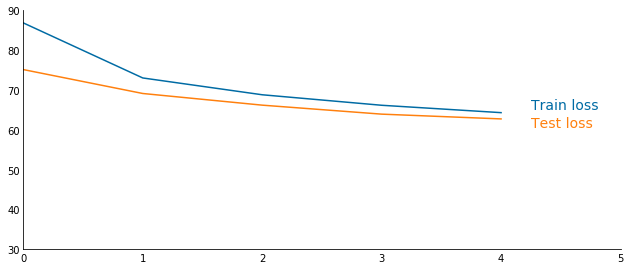

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)


tr = [np.mean(train_losses[start:start+len(train_loader)])  for start in range(0, len(train_losses), len(train_loader))]
plt.plot(tr, color=tableau20blind[0])

plt.xlim(0, len(tr))
te = [np.mean(valid_losses[start:start+len(valid_loader)]) for start in range(0, len(valid_losses), len(valid_loader))]
plt.plot(te, color=tableau20blind[1])

plt.text( len(tr)-0.75,tr[-1]+1,   'Train loss', color=tableau20blind[0], fontsize=14)
plt.text( len(te)-0.75,te[-1]-2, 'Test loss', color=tableau20blind[1], fontsize=14)

plt.ylim(30, 90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout(pad=5)
plt.gca().tick_params(axis='both', length=0)

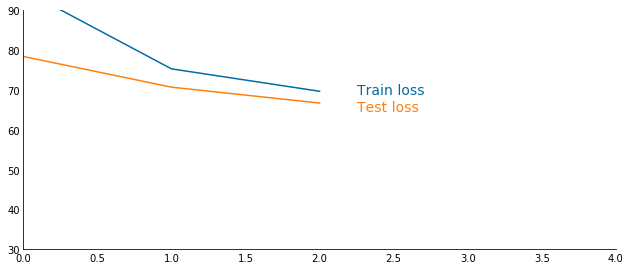

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
for i in range(len(tableau20blind)):
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)


tr = [np.mean(train_losses[start:start+len(train_loader)])  for start in range(0, len(train_losses), len(train_loader))]
plt.plot(tr[:-1], color=tableau20blind[0])

plt.xlim(0, len(tr))
te = [np.mean(valid_losses[start:start+len(valid_loader)]) for start in range(0, len(valid_losses), len(valid_loader))]
plt.plot(te, color=tableau20blind[1])

plt.text( len(tr)-1.75,tr[-1]+1,   'Train loss', color=tableau20blind[0], fontsize=14)
plt.text( len(te)-0.75,te[-1]-2, 'Test loss', color=tableau20blind[1], fontsize=14)

plt.ylim(30, 90)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.tight_layout(pad=5)
plt.gca().tick_params(axis='both', length=0)

In [ ]:
for epoch in range(5):
  print (f'Epoch {epoch}:')
  for inp, inp_len, op, op_len in tqdm(train_loader):
    
    inp, inp_len = inp.float().to(device), inp_len.long().to(device)
    op, op_len = op.long().to(device), op_len.long().to(device)

    optimizer.zero_grad()
    
    p = net(inp)
    
    loss = criterion(p.transpose(0,1), op, inp_len, op_len)
    # loss[loss == float("Inf")] = 0
    # print (loss.mean())
    
    loss = loss.mean()
    train_losses.append(loss.item())
    
    if np.isnan(train_losses[-1]):
        print ('NAN!')
        raise 'loss is nan'
    loss.backward()
    torch.nn.utils.clip_grad_norm_(net.parameters(), clip_value)
    
    optimizer.step()
    scheduler.step()
  print ('train loss = ', np.mean(train_losses[::-1][:len(train_loader)]))

  with torch.no_grad():
    for inp, inp_len, op, op_len in tqdm(valid_loader):
        
        inp, inp_len = inp.float().to(device), inp_len.long().to(device)
        op, op_len = op.long().to(device), op_len.long().to(device)
        p = net(inp)
        
        loss = criterion(p.transpose(0,1), op, inp_len, op_len)
        
        loss = loss.mean()
        valid_losses.append(loss.item())
    print ('valid loss = ', np.mean(valid_losses[::-1][:len(valid_loader)]))

Epoch 0:



train loss =  62.7362318688396



valid loss =  61.66185897230611
Epoch 1:



train loss =  61.469051133725685



valid loss =  60.34870283809709
Epoch 2:


In [32]:


import itertools
index2char = dict(zip(char2index.values(), char2index.keys()))
with torch.no_grad():
  for inp, inp_len, op, op_len in train_loader:
      
    inp, inp_len = inp.float().to(device), inp_len.long().to(device)
    op, op_len = op.long().to(device), op_len.long().to(device)

      

    p = net(inp)
    start = 0
    for pi, o in zip(p, op_len):
      
      
      print (''.join(index2char[i] for i in op[start:start+o].cpu().numpy()))
      for i in (k for k, g in itertools.groupby(pi.argmax(1).cpu().numpy())):
        
        if i < len(index2char):
          print (index2char[i], end = '')
      print ('\n')
      start += o
    break



<i know good crystal from bad and everything else there is to know about crystal>
<he ce ba knod  cresa ton dad> an debetinols theiristo no e crsto>

<from that day on the oasis would be an empty place for her>
<from tat tio> he hoisiswil beanento placfe ho>

<anything i can do back here>
<inli ding ican do bacc ya>r

<i don't want to>
<i don't mont ti f>

<vitriol has no place in this forum>
<thi tre ol hasn no placein tis forom>

<of course he's coming back here>
<a corsis come fa hir>r   

<could i please see you a minute>
<gi cipse youo minitt>r

<the night was warm and i was thirsty>
<te na was wore no was tasthe> 

<the alchemist dismounted and told the escorts they could return to the camp>
<the alcammestismnentod> and tod de casscos thi ca witchonto the cac>t

<he shrugged his shoulders>
<he srube hissol dhers>

<even an ordinary man has more than one horse power but gets tired quickly>
<even an now di noi man ter has mord anrond hosh taer> ut gitstaed grece>

<curiosity killed